In [1]:
import torch
import optuna
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
import wandb

In [3]:
wandb.init(mode="offline")

In [2]:
data = torch.load('./data/05_model_input/2024-02-monarch_heterodata_v1.pt', map_location='cpu')

In [3]:
print(f""" 
Total nodes: {data.num_nodes}
Total node types: {len(data.node_types)}

Total edges: {data.num_edges}
Total edge types: {len(data.edge_types)}                
""")

 
Total nodes: 862115
Total node types: 88

Total edges: 11412471
Total edge types: 289                



In [4]:
data['biolink:Gene'].num_nodes

559272

In [5]:
# Adding self loops to avoid 1. nodes without any edge, 2. consider intragenic modifier
from torch_geometric.transforms import AddSelfLoops

transform = AddSelfLoops()
data = transform(data)

In [6]:
data.has_isolated_nodes()

True

In [7]:
data.is_undirected()

False

In [8]:
metapaths = [
    ('biolink:Gene', 'biolink:orthologous_to', 'biolink:Gene'),
    ('biolink:Gene', 'biolink:interacts_with', 'biolink:Gene'),
    # ('biolink:Gene', 'biolink:actively_involved_in', 'biolink:BiologicalProcessOrActivity'),
    # ('biolink:Gene', 'biolink:acts_upstream_of_or_within', 'biolink:BiologicalProcessOrActivity'),
    # ('biolink:Gene', 'biolink:participates_in', 'biolink:Pathway'),
    # ('biolink:Pathway', 'biolink:related_to', 'biolink:BiologicalProcessOrActivity'),
    # ('biolink:Gene', 'biolink:has_phenotype', 'biolink:PhenotypicFeature'),
    # ('biolink:Disease', 'biolink:has_phenotype', 'biolink:PhenotypicFeature'),
    # ('biolink:Gene', 'biolink:gene_associated_with_condition', 'biolink:Disease'),
    # ('biolink:Gene', 'biolink:contributes_to', 'biolink:Disease'),
    # ('biolink:Gene', 'biolink:active_in', 'biolink:CellularComponent'),
    # ('biolink:Gene', 'biolink:expressed_in', 'biolink:CellularComponent'),
    # ('biolink:Gene', 'biolink:expressed_in', 'biolink:AnatomicalEntity'),
    # ('biolink:PhenotypicFeature', 'biolink:related_to', 'biolink:AnatomicalEntity'),
    # ('biolink:Gene', 'biolink:actively_involved_in', 'biolink:Pathway'),
    # ('biolink:MolecularEntity', 'biolink:participates_in', 'biolink:Pathway'),
    # ('biolink:Gene', 'biolink:acts_upstream_of', 'biolink:BiologicalProcessOrActivity'),
    # ('biolink:Gene', 'biolink:enables', 'biolink:BiologicalProcessOrActivity'),
    # ('biolink:Disease', 'biolink:related_to', 'biolink:BiologicalProcessOrActivity'),
    # ('biolink:Disease', 'biolink:related_to', 'biolink:PhenotypicFeature')
]


In [10]:
import torch
import pytorch_lightning as pl
from torch_geometric.nn import MetaPath2Vec

class MetaPath2VecLightningModule(pl.LightningModule):
    def __init__(self, edge_index_dict, metapaths, embedding_dim=128, walk_length=50, 
                 context_size=7, walks_per_node=5, num_negative_samples=5):
        super().__init__()
        self.save_hyperparameters()
        self.model = MetaPath2Vec(edge_index_dict, embedding_dim=self.hparams.embedding_dim,
                                  metapath=metapaths, walk_length=self.hparams.walk_length, 
                                  context_size=self.hparams.context_size,
                                  walks_per_node=self.hparams.walks_per_node, 
                                  num_negative_samples=self.hparams.num_negative_samples,
                                  sparse=True)

    def train_dataloader(self):
        loader = self.model.loader(batch_size=128, shuffle=True, num_workers=1)
        return loader

    def configure_optimizers(self):
        optimizer = torch.optim.SparseAdam(self.model.parameters(), lr=0.01)
        return optimizer

    def training_step(self, batch, batch_idx):
        pos_rw, neg_rw = batch
        loss = self.model.loss(pos_rw, neg_rw)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    # Optional: Define a validation step
    def validation_step(self, batch, batch_idx):
        # Implement your validation logic here, possibly using a different dataset
        # and returning some metric of interest, e.g., accuracy.
        pass

    # Optional: If your 'test' function is essential, integrate it here similarly to validation_step
    # def test_step(self, batch, batch_idx):
    #     pass

# We will use Comet for logging
comet_logger = CometLogger(project_name="modspy-monarch",
                            save_dir="./data/06_models/monarch-lightning/comet",
                            rest_api_key='NpKZhU5E8qdb0tJdJtlzoUugy',  # Optional
                            experiment_name="lightning_logs",  # Optional
                            )

# Prepare your model
model = MetaPath2VecLightningModule(data.edge_index_dict, metapaths)


# Setup the trainer
trainer = pl.Trainer(max_epochs=5, default_root_dir="data/06_models/monarch-lightning", accelerator="gpu", devices=2, num_nodes=1, strategy="ddp")
# trainer = pl.Trainer(max_epochs=5, default_root_dir="data/06_models/monarch-lightning", logger=comet_logger)
# trainer = pl.Trainer(max_epochs=5, gpus=1 if torch.cuda.is_available() else 0)

# Train the model
trainer.fit(model)


CometLogger will be initialized in offline mode
COMET WARNING: Failed to check backend version at URL: 'https://www.comet.com/clientlib/isAlive/ver'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rahit/jupyter_py3/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


In [28]:
list(sorted([(v.edge_index.shape[1],key) for (key,v) in data.edge_items()], reverse=True))

[(4096780, ('biolink:Gene', 'biolink:interacts_with', 'biolink:Gene')),
 (1472390,
  ('biolink:Gene',
   'biolink:expressed_in',
   'biolink:GrossAnatomicalStructure')),
 (883206,
  ('biolink:Gene', 'biolink:has_phenotype', 'biolink:PhenotypicFeature')),
 (841329,
  ('biolink:Gene', 'biolink:enables', 'biolink:BiologicalProcessOrActivity')),
 (747796,
  ('biolink:Gene',
   'biolink:actively_involved_in',
   'biolink:BiologicalProcessOrActivity')),
 (551383, ('biolink:Gene', 'biolink:orthologous_to', 'biolink:Gene')),
 (502219, ('biolink:Gene', 'biolink:located_in', 'biolink:CellularComponent')),
 (387549,
  ('biolink:Gene', 'biolink:expressed_in', 'biolink:AnatomicalEntity')),
 (241100,
  ('biolink:Disease', 'biolink:has_phenotype', 'biolink:PhenotypicFeature')),
 (227356,
  ('biolink:PhenotypicFeature',
   'biolink:subclass_of',
   'biolink:PhenotypicFeature')),
 (198370, ('biolink:Gene', 'biolink:participates_in', 'biolink:Pathway')),
 (168548,
  ('biolink:Gene',
   'biolink:acts_ups

In [22]:
sorted_etype = []
for k, e in data.edge_items():
    print(k)
    print(e[1].edge_index.shape[1])

('biolink:Gene', 'biolink:orthologous_to', 'biolink:Gene')


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 sorted_etype = []                                                                            │
│   2 for k, e in data.edge_items():                                                               │
│   3 │   print(k)                                                                                 │
│ ❱ 4 │   print(e[1].edge_index.shape[1])                                                          │
│   5                                                                                              │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/data/storage.py:118 in       │
│ __getitem__                                                                                      │
│                                                                                                  │
│   115 │   │   │   del self[key]                                                                  │
│   116 │                                                                                          │
│   117 │   def __getitem__(self, key: str) -> Any:                                                │
│ ❱ 118 │   │   return self._mapping[key]                                                          │
│   119 │                                                                                          │
│   120 │   def __setitem__(self, key: str, value: Any) -> None:                                   │
│   121 │   │   self._pop_cache(key)                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 1

In [11]:
# list(mapped_nodes.keys())
# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ['biolink:Gene', "biolink:MolecularEntity", 'biolink:Gene'],
    ['biolink:Gene', "biolink:SmallMolecule", 'biolink:Gene'],
    ['biolink:Gene', "biolink:ChemicalEntity", 'biolink:Gene'],
    ['biolink:Gene', "biolink:Cell", 'biolink:Gene'],
    ['biolink:Gene', "biolink:PhenotypicFeature", 'biolink:Gene'],
    ['biolink:Gene', "biolink:BiologicalProcessOrActivity", 'biolink:Gene'],
    ['biolink:Gene', "biolink:CellularComponent", 'biolink:Gene'],
    ['biolink:Gene', "biolink:LifeStage", 'biolink:Gene'],
    ['biolink:Gene', "biolink:Disease", 'biolink:Gene'],
    ['biolink:Gene', "biolink:PhenotypicQuality", 'biolink:Gene'],
    ['biolink:Gene', "biolink:CellularOrganism", 'biolink:Gene'],
    ['biolink:Gene', "biolink:PathologicalProcess", 'biolink:Gene'],
    ['biolink:Gene', "biolink:Pathway", 'biolink:Gene'],
    ['biolink:Gene', "biolink:Pathway", 'biolink:Gene'],
]


In [19]:
# list(mapped_nodes.keys())
# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ('biolink:Gene', "biolink:MolecularEntity", 'biolink:Gene'),
    ('biolink:Gene', "biolink:SmallMolecule", 'biolink:Gene'),
    ('biolink:Gene', "biolink:ChemicalEntity", 'biolink:Gene'),
    ('biolink:Gene', "biolink:Cell", 'biolink:Gene'),
    ('biolink:Gene', "biolink:PhenotypicFeature", 'biolink:Gene'),
    ('biolink:Gene', "biolink:BiologicalProcessOrActivity", 'biolink:Gene'),
    ('biolink:Gene', "biolink:CellularComponent", 'biolink:Gene'),
    ('biolink:Gene', "biolink:LifeStage", 'biolink:Gene'),
    ('biolink:Gene', "biolink:Disease", 'biolink:Gene'),
    ('biolink:Gene', "biolink:PhenotypicQuality", 'biolink:Gene'),
    ('biolink:Gene', "biolink:CellularOrganism", 'biolink:Gene'),
    ('biolink:Gene', "biolink:PathologicalProcess", 'biolink:Gene'),
    ('biolink:Gene', "biolink:Pathway", 'biolink:Gene'),
    ('biolink:Gene', "biolink:Pathway", 'biolink:Gene'),
]


In [11]:
# 1. Must be same node for end and begining of consicutive metapath
# 2. Must be circular
metapaths = [
    ('biolink:Gene', 'biolink:orthologous_to', 'biolink:Gene'),
    ('biolink:Gene', 'biolink:interacts_with', 'biolink:Gene'),
    ('biolink:Gene', 'biolink:expressed_in', 'biolink:GrossAnatomicalStructure')
]

# Since Monarch architecture does not have circular relationship (from paper we know) we will have to calculate embedding for different metapaths and then compress it together with another layer to get final aggregated embedding

In [ ]:
data.get_edge_index(['biolink:Gene', "biolink:Pathway", 'biolink:Gene'])

In [ ]:
import os.path as osp
import sys

import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Planetoid')
# dataset = Planetoid(path, name='Cora')
# data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    data['biolink:MolecularEntity'].edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

num_workers = 4 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


# @torch.no_grad()
# def test():
#     model.eval()
#     z = model()
#     acc = model.test(
#         train_z=z[data.train_mask],
#         train_y=data.y[data.train_mask],
#         test_z=z[data.test_mask],
#         test_y=data.y[data.test_mask],
#         max_iter=150,
#     )
#     return acc


for epoch in range(1, 101):
    loss = train()
    # acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: --')


# @torch.no_grad()
# def plot_points(colors):
#     model.eval()
#     z = model().cpu().numpy()
#     z = TSNE(n_components=2).fit_transform(z)
#     y = data.y.cpu().numpy()

#     plt.figure(figsize=(8, 8))
#     for i in range(dataset.num_classes):
#         plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
#     plt.axis('off')
#     plt.show()


# colors = [
#     '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
# ]
# plot_points(colors)

In [6]:
torch.cuda.is_available()

True

In [15]:
torch.cuda.empty_cache()

In [12]:
!nvidia-smi

Fri Mar  1 01:28:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-12GB           Off | 00000000:04:00.0 Off |                    0 |
| N/A   37C    P0              25W / 250W |      0MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [9]:
import ray

In [30]:
from torch_geometric.nn import MetaPath2Vec


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MetaPath2Vec(data.edge_index_dict, embedding_dim=128,
                     metapath=metapaths, walk_length=50, context_size=7,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=1)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train(epoch, log_steps=100, eval_steps=2000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))


# @torch.no_grad()
# def test(train_ratio=0.1):
#     model.eval()

#     z = model('author', batch=data['author'].y_index.to(device))
#     y = data['author'].y

#     perm = torch.randperm(z.size(0))
#     train_perm = perm[:int(z.size(0) * train_ratio)]
#     test_perm = perm[int(z.size(0) * train_ratio):]

#     return model.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
#                       max_iter=150)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

@torch.no_grad()
def test(n_clusters=10):
    """
    Test the learned embeddings by performing K-Means clustering and computing the Silhouette Score.
    
    Args:
    - embeddings (Tensor): The node embeddings learned by MetaPath2Vec, assumed to be a PyTorch tensor.
    - n_clusters (int): The number of clusters to use in K-Means.
    
    Returns:
    - silhouette_score (float): The Silhouette Score of the clustering, ranging from -1 to 1.
    """
    # Setting the mode to evaluation
    model.eval()
    embeddings = model('biolink:Gene')
    
    # Move embeddings to CPU and convert to NumPy for compatibility with scikit-learn
    embeddings_np = embeddings.cpu().detach().numpy()
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_np)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(embeddings_np, cluster_labels)
    
    print(f"Silhouette Score with {n_clusters} clusters: {silhouette_avg:.4f}")
    return silhouette_avg

accurace_trace = []

for epoch in range(1, 6):
    train(epoch)
    acc = test()
    accurace_trace.append(acc)
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│    2                                                                                             │
│    3                                                                                             │
│    4 device = 'cuda' if torch.cuda.is_available() else 'cpu'                                     │
│ ❱  5 model = MetaPath2Vec(data.edge_index_dict, embedding_dim=128,                               │
│    6 │   │   │   │   │    metapath=metapaths, walk_length=50, context_size=7,                    │
│    7 │   │   │   │   │    walks_per_node=5, num_negative_samples=5,                              │
│    8 │   │   │   │   │    sparse=True).to(device)                                                │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/nn/models/metapath2vec.py:94 │
│ in __init__                                                                                      │
│                                                                                                  │
│    91 │   │                                                                                      │
│    92 │   │   assert walk_length + 1 >= context_size                                             │
│    93 │   │   if walk_length > len(metapath) and metapath[0][0] != metapath[-1][-1]:             │
│ ❱  94 │   │   │   raise AttributeError(                                                          │
│    95 │   │   │   │   "The 'walk_length' is longer than the given 'metapath', but "              │
│    96 │   │   │   │   "the 'metapath' does not denote a cycle")                                  │
│    97                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: The 'walk_length' is longer than the given 'metapath', but the 'metapath' does not denote a cycle

In [ ]:
import lightning as L
from torch_geometric.nn import MetaPath2Vec


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = 

loader = model.loader(batch_size=128, shuffle=True, num_workers=1)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

# model
metapath_model = MetaPath2Vec(data.edge_index_dict, embedding_dim=128,
                     metapath=metapaths, walk_length=50, context_size=7,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

# train model
trainer = L.Trainer()
trainer.fit(model=metapath_model, train_dataloaders=train_loader)

In [14]:
# torch.save(model, './data/06_models/monarch_metapath2vec_v2.pt')

In [7]:
model = torch.load('./data/06_models/monarch_metapath2vec_v1.pt', torch.device('cpu'))

In [8]:
embeddings = model('biolink:Gene')
# Move embeddings to CPU and convert to NumPy for compatibility with scikit-learn
embeddings_np = embeddings.cpu().detach().numpy()

In [9]:
embeddings.shape

torch.Size([559270, 128])

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_np)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(embeddings_np, cluster_labels)

print(f"Silhouette Score with {10} clusters: {silhouette_avg:.4f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 cluster_labels = kmeans.fit_predict(embeddings_np)                                          │
│    7                                                                                             │
│    8 # Calculate Silhouette Score                                                                │
│ ❱  9 silhouette_avg = silhouette_score(embeddings_np, cluster_labels)                            │
│   10                                                                                             │
│   11 print(f"Silhouette Score with {10} clusters: {silhouette_avg:.4f}")                         │
│   12                                                                                             │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/sklearn/metrics/cluster/_unsupervised.py:117 │
│ in silhouette_score                                                                              │
│                                                                                                  │
│   114 │   │   │   X, labels = X[indices].T[indices].T, labels[indices]                           │
│   115 │   │   else:                                                                              │
│   116 │   │   │   X, labels = X[indices], labels[indices]                                        │
│ ❱ 117 │   return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))                   │
│   118                                                                                            │
│   119                                                                                            │
│   120 def _silhouette_reduce(D_chunk, start, labels, label_freqs):                               │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/sklearn/metrics/cluster/_unsupervised.py:237 │
│ in silhouette_samples                                                                            │
│                                                                                                  │
│   234 │   reduce_func = functools.partial(                                                       │
│   235 │   │   _silhouette_reduce, labels=labels, label_freqs=label_freqs                         │
│   236 │   )                                                                                      │
│ ❱ 237 │   results = zip(*pairwise_distances_chunked(X, reduce_func=reduce_func, **kwds))         │
│   238 │   intra_clust_dists, inter_clust_dists = results                                         │
│   239 │   intra_clust_dists = np.concatenate(intra_clust_dists)                                  │
│   240 │   inter_clust_dists = np.concatenate(inter_clust_dists)                                  │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1859 in          │
│ pairwise_distances_chunked                                                                       │
│                                                                                                  │
│   1856 │   │   │   D_chunk.flat[sl.start :: _num_samples(X) + 1] = 0                             │
│   1857 │   │   if reduce_func is not None:                                                       │
│   1858 │   │   │   chunk_size = D_chunk.shape[0]                                                 │
│ ❱ 1859 │   │   │   D_chunk = reduce_func(D_chunk, sl.start)

In [18]:
label = list(data.node_types)

In [14]:
data['biolink:Disease']

{'num_nodes': 26940, 'x': tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])}

In [ ]:
test()

In [9]:
# from tqdm import tqdm

embeddings = {}
node_types = set(data.node_types)  # Get unique node types from your graph data

for node_type in node_types:
    try:
        embeddings[node_type] = model(node_type).detach().cpu().numpy()  # Extract embeddings for each node type and move to CPU
    except KeyError:
        print(f"Warning: Embeddings for node type '{node_type}' not found. Skipping.")


In [10]:
embeddings.keys()

dict_keys(['biolink:Gene'])

In [6]:
import os
 
cpuCount = os.cpu_count()
print("Number of CPUs in the system:", cpuCount)

Number of CPUs in the system: 44


In [ ]:
import umap

embeddings_2d = {}  # To store 2D projections of embeddings

for node_type, emb in embeddings.items():
    reducer = umap.UMAP(random_state=42)
    embeddings_2d[node_type] = reducer.fit_transform(emb)  # Apply UMAP to each type's embeddings

In [11]:
from sklearn.manifold import TSNE
# from openTSNE import TSNE
# check cuML's UMAP projection

embeddings_2d = {}  # To store 2D projections of embeddings

for node_type, emb in embeddings.items():
    tsne = TSNE(n_components=2, random_state=42, n_jobs=32, verbose=True)
    embeddings_2d[node_type] = tsne.fit_transform(emb)  # Apply t-SNE to each type's embeddings


[02/29/24 04:13:49] WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/sklearn/manifold/_ ]8;id=561511;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=91468;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             t_sne.py:800: FutureWarning: The default initialization in TSNE will                  
                             change from 'random' to 'pca' in 1.2.                                                 
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/sklearn/manifold/_ ]8;id=255370;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=355821;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             t_sne.py:810: FutureWarning: The default learning rate in TSNE will                   
                             change from 200.0 to 'auto' in 1.2.                                                   
                               warnings.warn(                                                                      
                                                                                                                   

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 559270 samples in 0.065s...
[t-SNE] Computed neighbors for 559270 samples in 11740.966s...
[t-SNE] Computed conditional probabilities for sample 1000 / 559270
[t-SNE] Computed conditional probabilities for sample 2000 / 559270
[t-SNE] Computed conditional probabilities for sample 3000 / 559270
[t-SNE] Computed conditional probabilities for sample 4000 / 559270
[t-SNE] Computed conditional probabilities for sample 5000 / 559270
[t-SNE] Computed conditional probabilities for sample 6000 / 559270
[t-SNE] Computed conditional probabilities for sample 7000 / 559270
[t-SNE] Computed conditional probabilities for sample 8000 / 559270
[t-SNE] Computed conditional probabilities for sample 9000 / 559270
[t-SNE] Computed conditional probabilities for sample 10000 / 559270
[t-SNE] Computed conditional probabilities for sample 11000 / 559270
[t-SNE] Computed conditional probabilities for sample 12000 / 559270
[t-SNE] Computed conditional pro

In [12]:
import pickle
with open('data/07_model_output/monarch_embedding/computed-tsne.pkl', 'wb') as handle:
    pickle.dump(embeddings_2d, handle, protocol=pickle.HIGHEST_PROTOCOL)

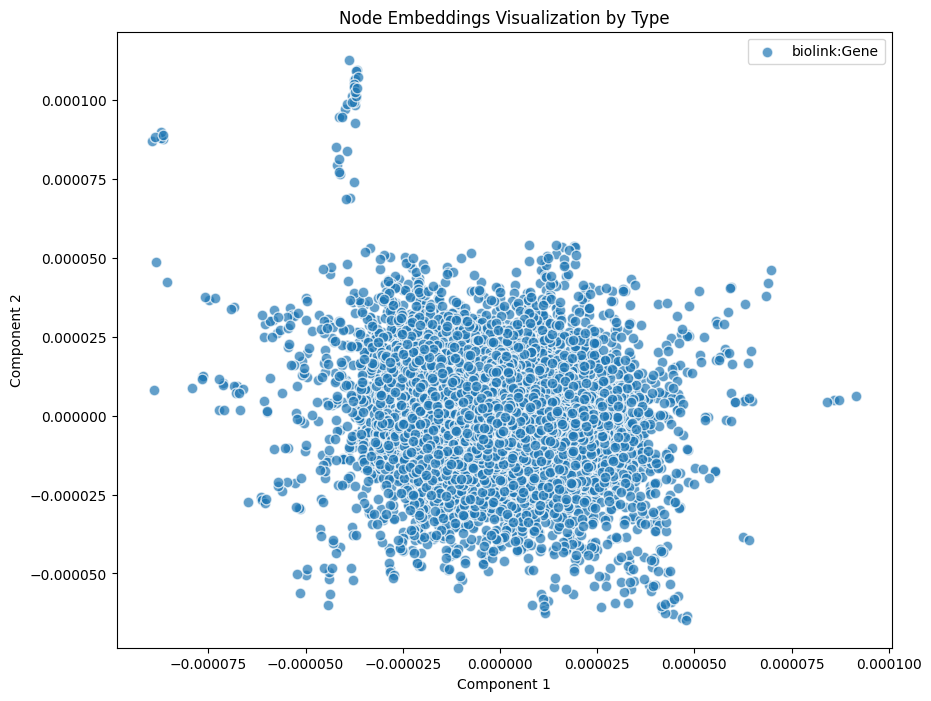

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for node_type, emb in embeddings_2d.items():
    plt.scatter(emb[:, 0], emb[:, 1], label=node_type, alpha=0.7, edgecolors='w', s=60)  # Plot each type's embeddings

plt.legend()
plt.title('Node Embeddings Visualization by Type')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [14]:
import os

In [15]:
!PATH=~/home/rahit/local/bin/proxychains4:$PATH
!export PROXYCHAINS_CONF_FILE=/home/rahit/conf/proxychains.conf

In [17]:
!/home/rahit/local/bin/proxychains4 wget https://data.monarchinitiative.org/monarch-kg-dev/latest/merged_graph_stats.yaml

[proxychains] config file found: /home/rahit/conf/proxychains.conf
[proxychains] preloading /home/rahit/local/lib/libproxychains4.so
[proxychains] DLL init: proxychains-ng 4.17
--2024-02-29 12:27:10--  https://data.monarchinitiative.org/monarch-kg-dev/latest/merged_graph_stats.yaml
Resolving data.monarchinitiative.org... 224.0.0.1
Connecting to data.monarchinitiative.org|224.0.0.1|:443... [proxychains] Strict chain  ...  127.0.0.1:9050  ...  timeout
failed: Connection refused.


In [20]:
!curl --socks5 graham.computecanada.ca:22 https://data.monarchinitiative.org/monarch-kg-dev/latest/merged_graph_stats.yaml

curl: (97) Received invalid version in initial SOCKS5 response.


In [ ]:
[rahit@gra-login2 ~]$ diskusage_report
                             Description                Space           # of files
                      /home (user rahit)              18G/51G            370k/500k
                   /scratch (user rahit)             890G/20T            29k/1000k
                  /project (group rahit)              0/2048k               0/1025
           /project (group def-mtarailo)            1587G/10T            105k/500k
--
On some clusters, a break down per user may be available by adding the option '--per_user'.
[rahit@gra-login2 ~]$ for FOLDER in $(find . -mindepth 1 -maxdepth 1 -type d); do   echo -ne "$FOLDER:\t";   find "$FOLDER" -type f | wc -l; done
./.w3m: 0
./.nv:  0
./files:        15
./.lmod.d:      1
./.vscode-server-bk:    33011
./.cargo:       20632
./.pki: 0
./bin:  1
./.licenses:    1
./.cache:       56769
./.mii: 0
./.local:       32793
./.jupyter:     9
./.dgl: 1
./.npm: 51
./.ssh: 3
./.cookiecutters:       396
./.ipython:     4
./.config:      7
./jupyter_py3:  153038
./nearline:     0
./.yarn:        0
./local:        3
./.spark:       1
./.cookiecutter_replay: 2
./.keras:       1
./.vscode-server:       19523
./conf: 1
./.elinks:      1
./projects:     0
./lib:  96

In [22]:
!ssh rahit:onaMi55ion!@graham.computecanada.ca

Password: 


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data['biolink:MolecularEntity'].edge_index, embedding_dim=128, 
            walk_length=20,                        # lenght of rw
            context_size=10, walks_per_node=20,
            num_negative_samples=1, 
            p=200, q=1,                             # bias parameters
            sparse=True).to(device)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 device = 'cuda' if torch.cuda.is_available() else 'cpu'                                      │
│ ❱ 2 model = Node2Vec(data['biolink:MolecularEntity'].edge_index, embedding_dim=128,              │
│   3 │   │   │   walk_length=20,                        # lenght of rw                            │
│   4 │   │   │   context_size=10, walks_per_node=20,                                              │
│   5 │   │   │   num_negative_samples=1,                                                          │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/data/storage.py:96 in        │
│ __getattr__                                                                                      │
│                                                                                                  │
│    93 │   │   try:                                                                               │
│    94 │   │   │   return self[key]                                                               │
│    95 │   │   except KeyError:                                                                   │
│ ❱  96 │   │   │   raise AttributeError(                                                          │
│    97 │   │   │   │   f"'{self.__class__.__name__}' object has no attribute '{key}'"             │
│    98 │   │   │   ) from None                                                                    │
│    99                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NodeStorage' object has no attribute 'edge_index'

In [12]:
model = MetaPath2Vec(data.edge_index_dict, embedding_dim=128, metapath=metapaths, walk_length=50, context_size=7, walks_per_node=10, num_negative_samples=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(num_epochs):
    model.train()
    total_loss = 0
    for _ in range(num_epochs):
        optimizer.zero_grad()
        pos_rw = model.positive_sample(data.edge_index_dict)
        neg_rw = model.negative_sample(pos_rw)
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

total_loss = train(1000)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:18                                                                                   │
│                                                                                                  │
│   15 │   │   total_loss += loss.item()                                                           │
│   16 │   return total_loss                                                                       │
│   17                                                                                             │
│ ❱ 18 total_loss = train(1000)                                                                    │
│   19                                                                                             │
│                                                                                                  │
│ in train:10                                                                                      │
│                                                                                                  │
│    7 │   total_loss = 0                                                                          │
│    8 │   for _ in range(num_epochs):                                                             │
│    9 │   │   optimizer.zero_grad()                                                               │
│ ❱ 10 │   │   pos_rw = model.positive_sample(data.edge_index_dict)                                │
│   11 │   │   neg_rw = model.negative_sample(pos_rw)                                              │
│   12 │   │   loss = model.loss(pos_rw, neg_rw)                                                   │
│   13 │   │   loss.backward()                                                                     │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch/nn/modules/module.py:1269 in           │
│ __getattr__                                                                                      │
│                                                                                                  │
│   1266 │   │   │   modules = self.__dict__['_modules']                                           │
│   1267 │   │   │   if name in modules:                                                           │
│   1268 │   │   │   │   return modules[name]                                                      │
│ ❱ 1269 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1270 │   │   │   type(self).__name__, name))                                                   │
│   1271 │                                                                                         │
│   1272 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'MetaPath2Vec' object has no attribute 'positive_sample'

In [32]:
import torch_geometric.transforms as T

transform = T.AddRandomWalkPE(walk_length=4, attr_name='pe')
post_data = transform(data)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 import torch_geometric.transforms as T                                                       │
│   2                                                                                              │
│   3 transform = T.AddRandomWalkPE(walk_length=4, attr_name='pe')                                 │
│ ❱ 4 post_data = transform(data)                                                                  │
│   5                                                                                              │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/transforms/base_transform.py │
│ :32 in __call__                                                                                  │
│                                                                                                  │
│   29 │   """                                                                                     │
│   30 │   def __call__(self, data: Any) -> Any:                                                   │
│   31 │   │   # Shallow-copy the data so that we prevent in-place data modification.              │
│ ❱ 32 │   │   return self.forward(copy.copy(data))                                                │
│   33 │                                                                                           │
│   34 │   def forward(self, data: Any) -> Any:                                                    │
│   35 │   │   pass                                                                                │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/transforms/add_positional_en │
│ coding.py:140 in forward                                                                         │
│                                                                                                  │
│   137 │   │   self.attr_name = attr_name                                                         │
│   138 │                                                                                          │
│   139 │   def forward(self, data: Data) -> Data:                                                 │
│ ❱ 140 │   │   assert data.edge_index is not None                                                 │
│   141 │   │   row, col = data.edge_index                                                         │
│   142 │   │   N = data.num_nodes                                                                 │
│   143 │   │   assert N is not None                                                               │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/data/hetero_data.py:159 in   │
│ __getattr__                                                                                      │
│                                                                                                  │
│    156 │   │   │   return getattr(self._global_store, key)                                       │
│    157 │   │   elif bool(re.search('_dict$', key)):                                              │
│    158 │   │   │   return self.collect(key[:-5])                                                 │
│ ❱  159 │   │   raise AttributeError(f"'{self.__class__.__name__}' has no "                       │
│    160 │   │   │   │   │   │   │    f"attribute '{key}'")                                        │
│    161 │                                                   

In [31]:
data.edge_index

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 data.edge_index                                                                              │
│   2                                                                                              │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/data/hetero_data.py:159 in   │
│ __getattr__                                                                                      │
│                                                                                                  │
│    156 │   │   │   return getattr(self._global_store, key)                                       │
│    157 │   │   elif bool(re.search('_dict$', key)):                                              │
│    158 │   │   │   return self.collect(key[:-5])                                                 │
│ ❱  159 │   │   raise AttributeError(f"'{self.__class__.__name__}' has no "                       │
│    160 │   │   │   │   │   │   │    f"attribute '{key}'")                                        │
│    161 │                                                                                         │
│    162 │   def __setattr__(self, key: str, value: Any):                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'HeteroData' has no attribute 'edge_index'

In [71]:
data.validate()

[02/23/24 04:40:52] WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/da ]8;id=299331;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=172803;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ta/data.py:1038: UserWarning: The node types {'biolink:Activity',                     
                             'biolink:NoncodingRNAProduct', 'biolink:RegulatoryRegion',                            
                             'biolink:GeographicExposure', 'biolink:Haplotype',                                    
                             'biolink:CodingSequence', 'biolink:DatasetDistribution',                              
                             'biolink:WebPage', 'biolink:Invertebrate', 'biolink:Attribute',                       
                             'biolink:ProteinDomain', 'biolink:BiologicalSex', 'biolink:Dataset',                  
                             'biolink:Snv', 'biolink:Mammal', 'biolink:OrganismalEntity',                          
                             'biolink:ChemicalMixture', 'biolink:Patent',                                          
                             'biolink:EnvironmentalProcess', 'biolink:PhenotypicSex',                              
                             'biolink:Procedure', 'biolink:Fungus', 'biolink:Treatment',                           
                             'biolink:Human', 'biolink:ProteinFamily', 'biolink:ConfidenceLevel',                  
                             'biolink:Study', 'biolink:Exon', 'biolink:Genotype',                                  
                             'biolink:MaterialSample', 'biolink:DiagnosticAid', 'biolink:Article',                 
                             'biolink:Bacterium', 'biolink:Event', 'biolink:SiRNA',                                
                             'biolink:GeneticInheritance', 'biolink:Agent', 'biolink:CellLine',                    
                             'biolink:ProcessedMaterial', 'biolink:Genome',                                        
                             'biolink:StudyVariable', 'biolink:ReagentTargetedGene',                               
                             'biolink:MicroRNA', 'biolink:Publication',                                            
                             'biolink:TranscriptionFactorBindingSite',                                             
                             'biolink:IndividualOrganism', 'biolink:Zygosity',                                     
                             'biolink:AccessibleDnaRegion', 'biolink:GenotypicSex',                                
                             'biolink:BiologicalEntity', 'biolink:PopulationOfIndividualOrganisms',                
                             'biolink:ChemicalExposure'} are isolated and are not referenced by any                
                             edge type                                                                             
                               warnings.warn(msg)                                                                  
                                                                                                                   

True

I tried to get random walk from the converted networkx graph. But do not have time to finish it rn.

In [6]:
from torch_geometric.utils import to_networkx
import networkx as nx

# Convert to a NetworkX graph for easier manipulation
G = to_networkx(data, to_multi=True)

In [9]:

print(f""" 
Total nodes: {G.number_of_nodes()}
Total edges: {G.number_of_edges()}           
""")

Total nodes: 862115
Total edges: 11412471

In [12]:
G[185]

AdjacencyView({1242: {0: {'type': ('biolink:PhenotypicFeature', 'biolink:subclass_of', 'biolink:PhenotypicFeature')}}, 160687: {0: {'type': ('biolink:PhenotypicFeature', 'biolink:related_to', 'biolink:BiologicalProcessOrActivity')}}})

In [27]:
for a in G[185].items():
    print(a[0])
    print(a[1][0]['type'])

1242

('biolink:PhenotypicFeature', 'biolink:subclass_of', 'biolink:PhenotypicFeature')

160687

('biolink:PhenotypicFeature', 'biolink:related_to', 'biolink:BiologicalProcessOrActivity')

In [ ]:
G['biolink:Gene'].neighbours

In [ ]:
import random

def random_walk_hetero(graph, start_node, walk_length, node_type, edge_type):
    # Initialize the walk
    walk = [start_node]
    
    # Perform the walk
    for _ in range(walk_length):
        current_node = walk[-1]
        for n, nbrsdict in G.adjacency():
            for nbr, keydict in nbrsdict.items():
                for key, eattr in keydict.items():
                    if "weight" in eattr:
                        # Do something useful with the edges
                        pass
        neighbors = [n for n in G[current_node] if n[1][0]['type'] == edge_type]
        if neighbors:
            walk.append(random.choice(neighbors))
        else:
            break  # No more neighbors of the desired type

    return walk

# Example usage
start_node = 0  # Assuming this is a valid node ID in your graph
walk_length = 10
node_type = 'biolink:Gene'
edge_type = 'edge_type_1'
walk = random_walk_hetero(G, start_node, walk_length, node_type, edge_type)
print(walk)


In [17]:
cluster.close()

[02/22/24 23:46:44] INFO     Scheduler closing...                                                 ]8;id=295869;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=433701;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#3949\3949]8;;\

                    INFO     Scheduler closing all comms                                          ]8;id=274560;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=69727;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#3971\3971]8;;\

In [18]:
client.close()